In [1]:
import matplotlib

%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
import time
from rr_python_sdk import cpp, MeasurementHead, msg_map_to_host

# Make head object (and handshake)

In [2]:
head = MeasurementHead()

USB Serial Port (COM8) 1027
Auto detected: USB Serial Port (COM8)
Handshake acknowledged: <rr_python_sdk.mh_protocol_py.HandshakeToHostPayload object at 0x00000193D41341B0>


In [67]:
head.restart()

## Optionally, rehandshake
Eg if device disconnects without serial diconenction from the usb bridge board, or if device restarts

In [82]:
head.shakehands()

Handshake acknowledged: <rr_python_sdk.mh_protocol_py.HandshakeToHostPayload object at 0x00000243602E9D70>


True

# Home and tare forces
Home the actuator, and tare the forces (needed before sensible force data can be collected)

In [9]:
head.home()

In [19]:
head.zero_forces()

# Read single or all mesages from the device

In [40]:
def print_simple_message(msg):
    if msg.type == cpp.MsgType_ToHost.ACK:
        print(f"Head acknowlages message: {msg.data.msg_type}")
    elif msg.type == cpp.MsgType_ToHost.ERR:
        print(f"Head negative acknowlages message: {msg.data.msg_type}")
    elif msg.type == cpp.MsgType_ToHost.NewFault:
        print(f"Instruction caused fault, fault must be cleared before operation {msg.data.reason}")
    elif msg.type != cpp.MsgType_ToHost.NoMessage:
        print(f"Message type: {msg.type}, Msg data: {msg.data}")
    else:
        print("No message recieved")
        return None
    return msg.data

In [70]:
msg = head.read()
data = print_simple_message(msg)

No message recieved


In [54]:
msgs = head.read_all(timeout=0)
for msg in msgs:
    print_simple_message(msg)

# Check or clear fault status
If some physical problem is encountered (eg: limit switch hit while active, move out of range, over load etc.) The head will generate a NewFault message and stop what it is doing. This fault indicates some physical problem with the device, it needs to be cleared before the device will function again. 

The fault status can be inspected with request fault data, only a 0 status code means no fault is present.

The fault status can be cleared by clear_fault, the fault status also resets on device restart

In [57]:
head.read_all(timeout = 0) # flush any waiting messages

head.request_fault_data()
msg = head.read()
print(f"Status code: {msg.data.fault_status}")

Status code: 0


In [20]:
head.clear_fault()

# Requesting force data
Force data can be requested either one point at a time or continuously streamed the two cells below show examples of each

In [11]:
head.read_all(timeout=0)
head.request_current_force_data()
msg = head.read()
if msg.type == cpp.MsgType_ToHost.CurrentData:
    print(f"Status: {int(msg.data.device_status):032b}\tFn: {msg.data.f_normal_mn/1000:.2f}\tFt: {msg.data.f_tangential_mn/1000:.2f}")

Status: 10000000001110000011011010101000	Fn: 5.14	Ft: 167.56


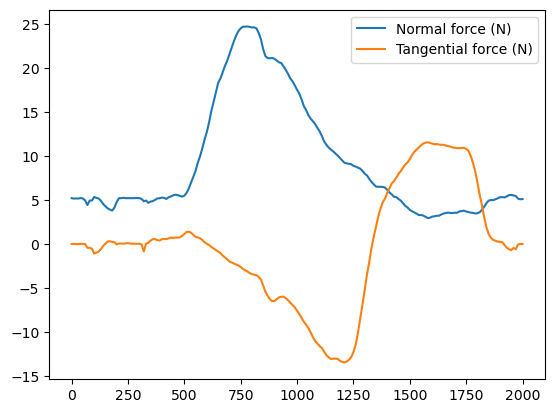

In [31]:
def plot_force_data(data_rate = 100, duration=2):
    points = []
    head.read_all(timeout = 0.1)
    pl = cpp.DataRatePayload()
    pl.rate_hz = data_rate
    head.start_data_streaming(pl)
    while (len(points)<duration*data_rate):
        points.extend([msg for msg in head.read_all() if msg.type==cpp.MsgType_ToHost.CurrentData])
    head.stop_data_streaming()
    #plt.plot([p.ms_since_start for p in points], [p.f_t_mn/p.f_n_mn for p in points], label="mu")
    plt.plot([p.data.millis_since_start for p in points], [p.data.f_normal_mn/1000 for p in points], label="Normal force (N)")
    plt.plot([p.data.millis_since_start for p in points], [p.data.f_tangential_mn/1000 for p in points], label="Tangential force (N)")
    plt.legend()
    plt.show()

plot_force_data()

In [32]:
head.read_all(timeout =0.1)

[Message(type=<MsgType_ToHost.CurrentData: 68>, data=<rr_python_sdk.mh_protocol_py.ForceDataPoint object at 0x00000243602FF1F0>),
 Message(type=<MsgType_ToHost.ACK: 6>, data=<rr_python_sdk.mh_protocol_py.AckPayload object at 0x00000243606B5330>)]

# Setting and updating the normal force
The normal force can be set or updated while in contact as shown in the following 2 cells. To stop force control, you can simply tell the device to go home

In [33]:
payload = cpp.SetForcePayload()
payload.force_mn = 100000
head.start_force_control(payload)

In [34]:
payload = cpp.SetForcePayload()
payload.force_mn = 150000
head.update_set_force(payload)

In [35]:
head.home()

Alternativelyhead.abort_move() the head can be immediately stopped:

In [114]:
head.abort_move()

# Updating configuration
The device exposes many configuration options in a config struct, the simplest way to update these without invalidating the device config is to first read the config from the device, edit it and write it back to the device. The device will either acknowlage this or generate an error, and revert to the original config. The config cannot be updated when the device is maintaining a force or streaming data.

When the config is written to the device ram it will persist until the device is restarted. If you wish to save the new config so it persists indefinately, you must save the config to the device flash.

At any point the factory default config can be reloaded using reset_to_defaults. This immdeiately writes the default config to the flash and triggers a restart of the device.

In [74]:
head.read_all(timeout = 0.1)
head.request_config()
msg = head.read()
if msg.type == cpp.MsgType_ToHost.ConfigData:
    msg.data.normal_lc.minimum_zero_offset = 130
    head.write_config(msg.data)
msg = head.read()
if msg.type == cpp.MsgType_ToHost.ACK and msg.data.msg_type == cpp.MsgType_ToDevice.WriteConfig:
    print("Config successfully updated (RAM only)")

Config successfully updated (RAM only)


In [77]:
head.write_config_to_flash()
msg = head.read()
if msg.type == cpp.MsgType_ToHost.ACK and msg.data.msg_type == cpp.MsgType_ToDevice.WriteConfigToFlash:
    print("Config update on flash")

Config update on flash


In [91]:
head.reset_to_defaults() 
time.sleep(2)
head.shakehands()

Handshake acknowledged: <rr_python_sdk.mh_protocol_py.HandshakeToHostPayload object at 0x00000243602A5D70>


True

## Tuning the pid controller
The PID controller in the device can be tuned while the device is maintaining a force. 

The cell below indicates how this is done. Note that these changes are only to the RAM of the device, if you want tuning changes to persist the config must be written to the device flash as described above

The diferential of the device signal is calculated by decaying weight least squares, the diferential decay value controls this decay. It should be greater than 0 and less than 1.

In [99]:
payload = cpp.SetForcePayload()
payload.force_mn = 100000
head.start_force_control(payload)

In [98]:
payload = cpp.PidConfig()
payload.diferential_decay = 0.5
payload.n_settle = 20
payload.PID_P = 0.0008
payload.PID_D = 40
payload.settle_tollerance = 0.02
head.update_pid_config(payload)

In [100]:
head.home()

# Restarting the head
The head can be remotely restarted, you will need to complete the handshake when it has booted in order to communicate with it

In [118]:
head.restart()
time.sleep(2)
head.shakehands()

Handshake acknowledged: <rr_python_sdk.mh_protocol_py.HandshakeToHostPayload object at 0x000002436032D6B0>


True

# Jogging the motor
The normal axis of the head can be jogged, note that unless the head is streaming data the load cells will not be read duing this process and the motor will not stop if they are being over loaded.

In [101]:
payload = cpp.JogPayload()
payload.distance_mm = 5.0
head.jog_motor(payload)

# Orientation data
The head contains an accelerometer that can be used to measure the roll and incline during a measurment. These can tell you if the trak you are on is inclined either up or down hill, or if the head is rolled from vertical (eg if you are measuring at the gauge face). Angles are in degrees.

In [4]:
head.read_all(timeout = 1)
head.request_orientation()
msg = head.read()
if msg.type == cpp.MsgType_ToHost.OrientationData:
    print(f"Incline: {msg.data.incline}\tRoll: {msg.data.roll}")

Incline: -0.6274077892303467	Roll: 0.03151371702551842
